In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt


In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MyCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        # Compute flattened feature size dynamically
        with torch.no_grad():
            x = torch.zeros(1, 1, 28, 28)  # 28 x 28 is the input image size for Fashion-MNIST
            n_features = self.features(x).numel()

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_features, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )
 
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
 
print(f"Model has {sum(p.numel() for p in CNN().parameters())} parameters.")

        

Model has 421642 parameters.


In [ ]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimiser, scheduler, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimiser = optimiser
        self.scheduler = scheduler
        self.device = device
        self.history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
 
        print(f"Using device: {self.device}")
 
    def train_epoch(self, epoch, num_epochs):
        self.model.train()
        train_loss = 0.0
        loop = tqdm(self.train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
 
        for inputs, targets in loop:
            inputs, targets = inputs.to(self.device), targets.to(self.device)
 
            self.optimiser.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimiser.step()
 
            train_loss += loss.item() * inputs.size(0)
            loop.set_postfix(loss=loss.item())
 
        return train_loss / len(self.train_loader.dataset)
 
    def validate(self):
        self.model.eval()
        val_loss = 0.0
        correct = 0
 
        with torch.no_grad():
            for inputs, targets in self.val_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
 
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == targets).sum().item()
 
        val_loss /= len(self.val_loader.dataset)
        val_acc = correct / len(self.val_loader.dataset)
        return val_loss, val_acc
 
    def train(self, num_epochs):
        for epoch in range(num_epochs):
            train_loss = self.train_epoch(epoch, num_epochs)
            val_loss, val_acc = self.validate()
 
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
 
            self.scheduler.step(val_loss)
 
            print(f"Epoch [{epoch+1}/{num_epochs}] - "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}")
 
        print("Training complete.")
        return self.history
 
# %%
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
 
    plt.figure(figsize=(12, 5))
 
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
 
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
 
    plt.show()

Using device: cuda


Epoch [1/10]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [1/10] - Train Loss: 0.1875, Val Loss: 0.0615, Val Acc: 0.9802


Epoch [2/10]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [2/10] - Train Loss: 0.0511, Val Loss: 0.0458, Val Acc: 0.9839


Epoch [3/10]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [3/10] - Train Loss: 0.0349, Val Loss: 0.0401, Val Acc: 0.9866


Epoch [4/10]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [4/10] - Train Loss: 0.0258, Val Loss: 0.0294, Val Acc: 0.9907


Epoch [5/10]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [5/10] - Train Loss: 0.0194, Val Loss: 0.0371, Val Acc: 0.9884


Epoch [6/10]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [6/10] - Train Loss: 0.0159, Val Loss: 0.0333, Val Acc: 0.9897


Epoch [7/10]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [7/10] - Train Loss: 0.0134, Val Loss: 0.0276, Val Acc: 0.9910


Epoch [8/10]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [8/10] - Train Loss: 0.0107, Val Loss: 0.0303, Val Acc: 0.9921


Epoch [9/10]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [9/10] - Train Loss: 0.0086, Val Loss: 0.0343, Val Acc: 0.9905


Epoch [10/10]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [10/10] - Train Loss: 0.0065, Val Loss: 0.0313, Val Acc: 0.9916
Training complete.
Final Validation Loss: 0.0313, Final Validation Accuracy: 0.9916


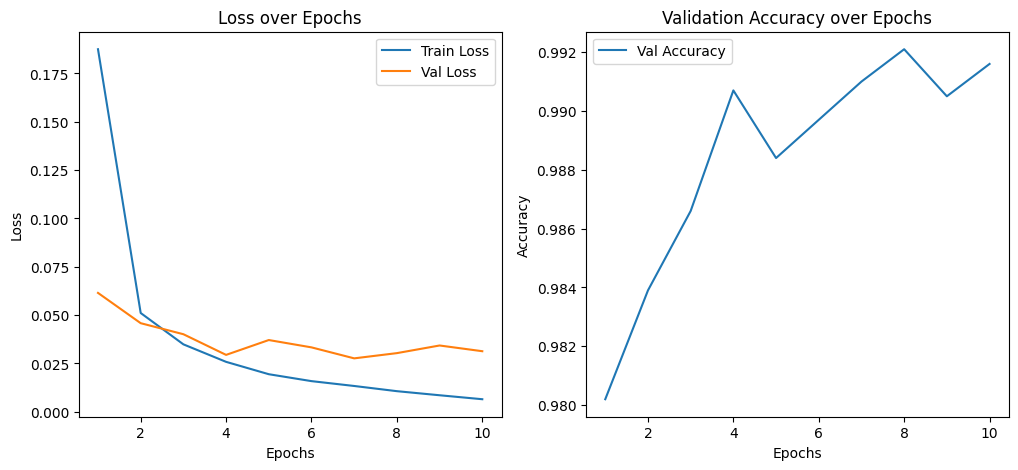

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
transforms = transforms.Compose([
    transforms.ToTensor(),
])
 
train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
val_ds = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)
 
train_loader = DataLoader.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
 
model = CNN(num_classes=10).to(device)
cirterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.1, patience=3)
 
trainer = ModelTrainer(model, train_loader, val_loader, cirterion, optimiser, scheduler, device)
 
history = trainer.train(NUM_EPOCHS)
 
final_loss, final_acc = trainer.validate()
print(f"Final Validation Loss: {final_loss:.4f}, Final Validation Accuracy: {final_acc:.4f}")
plot_history(history)